### Annotation tool
**by Michael Tkachuk. Please give credits upon reuse**  
  
  
Basic use:
- provide configuration in the following cell
- modify frame_processing function if additional markup needed
- modify postprocessing cell if needed

In [1]:
from IPython.display import display

from ipywidgets import Button, Image, interact, interact_manual, TwoByTwoLayout, FloatText, Label, HBox, IntText, Layout

import cv2 as cv
import PIL.Image
import io
import numpy as np
import json
import os

INTERVAL = 5
VID_PATH = "../data/raw/video/video.mp4"
META_PATH = "../data/raw/meta/meta.json"
OUTPUT_PATH = "../data/raw/meta/"

os.makedirs(OUTPUT_PATH, exist_ok=True)

In [2]:
def slide(cap, forward=True, n=INTERVAL):
    if forward:
        if slide.frame_cursor + n < cap.get(cv.CAP_PROP_FRAME_COUNT):
            slide.frame_cursor += n
    else:
        if slide.frame_cursor > 0:
            slide.frame_cursor -= n
    if slide.frame_cursor > cap.get(cv.CAP_PROP_POS_FRAMES):
        while slide.frame_cursor != cap.get(cv.CAP_PROP_POS_FRAMES):
            _ = cap.read()
    if slide.frame_cursor == cap.get(cv.CAP_PROP_POS_FRAMES):
        ret, frame = cap.read()
        if not ret:
            frame = None
        slide.frames_cache.append(frame)
    else:
        frame = slide.frames_cache[slide.frame_cursor//n]  
        
    return cv.cvtColor(frame, cv.COLOR_BGR2RGB)
slide.frame_cursor = 0
slide.frames_cache = []

In [3]:
def frame_processing(frame):
    cv.line(frame,(605,200),(605,650),(0,255,100),1)
    return frame

In [4]:
def compress_to_bytes(data, fmt='png'):
    """
    Helper function to compress image data via PIL/Pillow.
    Also make some markup on-frame
    """
    data = frame_processing(data)
    buff = io.BytesIO()
    img = PIL.Image.fromarray(data)    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

In [5]:
# init video reader and render first frame

cap = cv.VideoCapture(VID_PATH)
slide.frame_cursor = -INTERVAL
slide.frames_cache = []

canvas = Image(value=compress_to_bytes(slide(cap)))

# create or load a checkpoint.json file

try:
    with open(os.path.join(OUTPUT_PATH, 'checkpoint.json')) as f:
        annotations = json.load(f)
except:
    annotations = {}

# define annotation and frame rendering functions

def render(b, cap, canvas_=canvas, forward=True, n=INTERVAL):
    canvas_.value = compress_to_bytes(slide(cap, forward=forward, n=n))
    current.value = f'cursor at: {slide.frame_cursor}'
    
def annotate(b, val):
    print(val.value)
    annotations[str(slide.frame_cursor)] = val.value
    annotations[str(slide.frame_cursor)]
    with open(os.path.join(OUTPUT_PATH, 'checkpoint.json'), 'w') as f:
        json.dump(annotations, f)
    
def jump(b, pos):
    pos = pos.value
    if pos > slide.frame_cursor:
        for _ in range((pos - slide.frame_cursor)//INTERVAL - 1): # jump to closest position frame_curser < pos - INTERVAL
            slide(cap, forward=True)
        render(b, cap,) # render one step forward to be closest position frame_curser < pos
    elif pos < slide.frame_cursor:
        for _ in range((slide.frame_cursor - pos)//INTERVAL -1): # jump to closest position frame_curser < pos - INTERVAL
            slide(cap, forward=False)
        render(b, cap,forward=False) # render one step forward to be closest position frame_curser < pos
    else:
        return
    

r = Button(description='Forward')
r.on_click(lambda x: render(x, cap))

l = Button(description='Back')
l.on_click(lambda x: render(x, cap, forward=False))

val = FloatText(val=0)

confirm = Button(description='Set')
confirm.on_click(lambda x: annotate(x, val))

current = Label(value=f'cursor at: {slide.frame_cursor}')
jump_to = IntText(val=0, layout=Layout(width='15%'))
jump_button = Button(description='Jump')
jump_button.on_click(lambda x: jump(x, jump_to))

layout = TwoByTwoLayout(top_left=l,
                        top_right=r,
               bottom_left=HBox([val, confirm]),
               bottom_right=HBox([current, jump_to, jump_button]))

display(canvas)
display(layout)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\xa0\x00\x00\x05\xa0\x08\x02\x00\x00\x00\'\xc2s\x…

TwoByTwoLayout(children=(Button(description='Back', layout=Layout(grid_area='top-left'), style=ButtonStyle()),…

#### Postprocessing cell

In [27]:
multiplier = 2*np.pi/141.2

with open(os.path.join(OUTPUT_PATH, 'checkpoint.json')) as f:
    annotations = json.load(f)
keys = sorted(list(annotations.keys()), key=lambda x: int(x))

In [28]:
out = {}
for i in range(1,len(keys)):
    dst_interpolation = np.linspace(annotations[keys[i-1]], annotations[keys[i]], int(keys[i]) - int(keys[i-1])+1)
    dst_interpolation *= multiplier
    for frame, dst in zip(range(int(keys[i-1]),int(keys[i])),dst_interpolation):
        out[frame-186+65] = f'{dst:.5f}'
with open(os.path.join(OUTPUT_PATH, 'theta.json'), 'w') as f:
    json.dump(out, f)

In [29]:
"""
Metadata info
"""
with open(os.path.join(META_PATH)) as m:
    meta = json.load(m)
meta['trim'] = [65, 2680]
with open(os.path.join(META_PATH), 'w') as m:
    json.dump(meta, m)

In [30]:
step = observations[-1] / len(observations)
obs_index = np.array([int(k) for k in keys][9:])
observations = np.array([annotations[k] for k in keys][9:])
linear = np.array([(0 + step * i) for i in range(len([annotations[k] for k in keys][9:]))])

In [31]:
import pandas as pd

dataframe = pd.DataFrame(
    np.array([obs_index, linear, observations]).T, 
    columns=["obs_index", "linear", "observations"]
)
dataframe["diff"] = dataframe["linear"] - dataframe["observations"]
dataframe["diff_lag"] = dataframe["diff"].diff()

In [32]:
dataframe

,obs_index,linear,observations,diff,diff_lag
0,180.0,0.000000,0.0,0.000000,NaN
1,200.0,1.063910,0.5,0.563910,0.56391
2,220.0,2.127820,1.5,0.627820,0.06391
3,240.0,3.191729,2.5,0.691729,0.06391
4,260.0,4.255639,3.6,0.655639,-0.03609
...,...,...,...,...,...
128,2740.0,136.180451,137.7,-1.519549,-0.03609
129,2760.0,137.244361,138.7,-1.455639,0.06391
130,2780.0,138.308271,139.8,-1.491729,-0.03609
131,2800.0,139.372180,140.8,-1.427820,0.06391


In [23]:
dataframe.loc[abs(dataframe["diff_lag"]) >= .5, :]

,obs_index,linear,observations,diff,diff_lag
1,200.0,1.06391,0.5,0.56391,0.56391


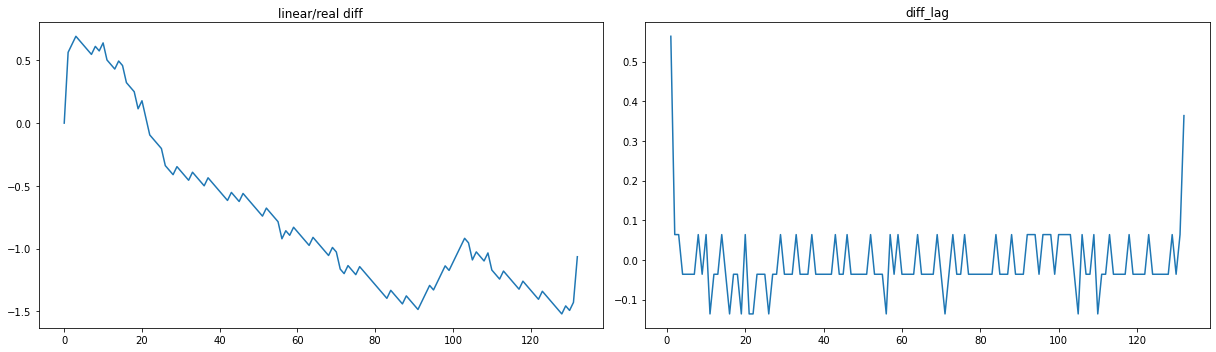

In [25]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
dataframe["diff"].plot(ax=axes[0])
dataframe["diff_lag"].plot(ax=axes[1])
axes[0].set_title("linear/real diff")
axes[1].set_title("diff_lag")
plt.tight_layout()
plt.show()

In [160]:
# annotations = {k: v for k, v in sorted(annotations.items(), key=lambda item: item[1])}

In [37]:
from pathlib import Path
import cv2
images = [x for x in Path("../data/raw/images").glob("*.jpg")]

In [55]:
h, w, _ = cv2.imread(str(images[0])).shape

image = cv2.imread(str(images[0]))

image = image[20: h - 620, 320: w - 320]

image.shape

(800, 800, 3)

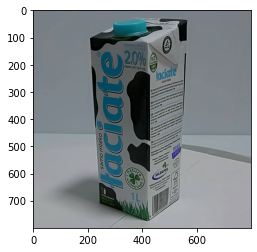

In [56]:
plt.imshow(image)